In [35]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel

In [36]:
#generate the sample
def gen_data():
    N = 1000
    beta = 3
    x = np.random.normal(loc=0, scale=1, size=N)
    e = np.random.logistic(size=N)
    y = 1*(1 + beta * x + e >= 0) 
    return y,x,N

In [37]:
class SimulatedLikelihood(GenericLikelihoodModel):
    
    def __init__(self,*args,  sim_function=np.random.logistic, **kwargs):
        super(SimulatedLikelihood, self).__init__(*args, **kwargs)
        #do the simulation 1x instead of on every step
        nsim = 2000
        np.random.seed(0)
        e = sim_function(size=nsim)
        e = np.repeat(e, self.endog.shape[0])
        self.sims = e.reshape((nsim,self.endog.shape[0]))
        
    
    def loglike(self, params):
        
        exog = self.exog
        endog = self.endog
        u = np.dot(exog, params)
        
        #generate simulations
        e = self.sims
        
        #compare to each sim
        u = np.tile(u,(e.shape[0],1))
        u = u.reshape((e.shape[0],endog.shape[0]))
               
        #compute likelihood
        p0, p1 = (u<=e).mean(axis=0), (u >= e).mean(axis=0)
        p = (1-endog)*p0 +  endog*p1
        ll = np.log( np.maximum(p,.0001) )#help with numerical zeros
        
        return ll.sum() 

In [38]:
yn,xn, N = gen_data()
model1 = sm.Probit(yn,sm.add_constant(xn))
model1_res = model1.fit(disp=False)
print(model1_res.summary())
    
model2 = SimulatedLikelihood(yn,sm.add_constant(xn),sim_function=np.random.normal)
model2_res = model2.fit(disp=False)
print(model2_res.summary())

                          Probit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1000
Model:                         Probit   Df Residuals:                      998
Method:                           MLE   Df Model:                            1
Date:                Thu, 09 Jul 2020   Pseudo R-squ.:                  0.4889
Time:                        16:34:56   Log-Likelihood:                -345.40
converged:                       True   LL-Null:                       -675.75
Covariance Type:            nonrobust   LLR p-value:                1.052e-145
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5067      0.058      8.746      0.000       0.393       0.620
x1             1.7286      0.098     17.701      0.000       1.537       1.920
                          SimulatedLikelihood Result

/home/erichschulman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [39]:
yn,xn, N = gen_data()
model1 = sm.Logit(yn,sm.add_constant(xn))
model1_res = model1.fit(disp=False)
print(model1_res.summary())
    
model2 = SimulatedLikelihood(yn,sm.add_constant(xn))
model2_res = model2.fit(disp=False)
print(model2_res.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      998
Method:                           MLE   Df Model:                            1
Date:                Thu, 09 Jul 2020   Pseudo R-squ.:                  0.5102
Time:                        16:34:58   Log-Likelihood:                -333.86
converged:                       True   LL-Null:                       -681.55
Covariance Type:            nonrobust   LLR p-value:                3.008e-153
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8413      0.107      7.879      0.000       0.632       1.051
x1             3.2670      0.206     15.890      0.000       2.864       3.670
                          SimulatedLikelihood Result

[482547.80372472  45959.88264448]


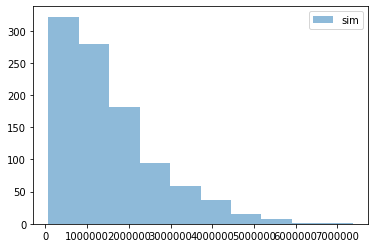

In [40]:
# next sampling
sample = np.random.chisquare(3, size=(1000,2) )

hessian2 = np.linalg.inv( model2_res.normalized_cov_params)
values2, vectors = np.linalg.eig(hessian2)
print(values2)
np.random.seed(0)
sample2 = np.dot(sample,values2)
plt.hist(sample2,alpha=0.5,label="sim")

plt.legend()
plt.show()

[111.05007752  22.38814935]


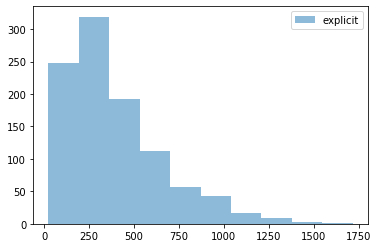

In [41]:
#comapre test distributions
hessian1 = np.linalg.inv( model1_res.normalized_cov_params)
values1, vectors = np.linalg.eig(hessian1)
print(values1)
np.random.seed(0)
sample1 = np.dot(sample,values1)
plt.hist(sample1,alpha=0.5,label="explicit")


plt.legend()
plt.show()